### Demo notebook for model trained on CheXpert dataset

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#import efficientnet.tfkeras
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from tensorflow.keras.models import load_model
from keras.utils.data_utils import get_file
from PIL import Image


IMAGE_SIZE = 224

# https://github.com/stanfordmlgroup/chexpert-labeler/tree/master/phrases/mention
classes = [
    'No Finding',
    'Enlarged- \nCardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices'
]


def preprocess_image(uploaded_file):
    # Load image
    img_array = np.array(Image.open(uploaded_file))
    # Normalize to [0,1]
    img_array = img_array.astype('float32')
    img_array /= 255
    # Check that images are 2D arrays
    if len(img_array.shape) > 2:
        img_array = img_array[:, :, 0]
    # Convert to 3-channel
    img_array = np.stack((img_array, img_array, img_array), axis=-1)
    # Convert to array
    img_array = cv2.resize(img_array, (IMAGE_SIZE, IMAGE_SIZE))
    return img_array


def get_model():
    URL = "https://github.com/hasibzunair/cxr-predictor/releases/latest/download/CheXpert_DenseNet121_res224.h5"
    weights_path = get_file(
               "CheXpert_DenseNet121_res224.h5",
               URL)
    model = load_model(weights_path, compile = False)
    return model

def make_prediction(file):
    # Preprocess input image
    image = preprocess_image(file)
    # Add batch axis
    image = np.expand_dims(image, 0)
    # Predict
    predictions = model.predict(image)
    return predictions


Using TensorFlow backend.


In [2]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [3]:
uploaded_file = "/home/hasib/Desktop/p2.jpg"

In [4]:
img = np.array(Image.open(uploaded_file))

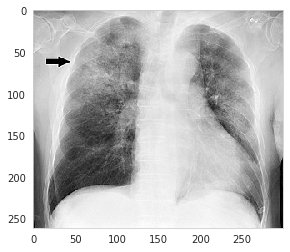

In [5]:
plt.imshow(img, cmap='gray')
plt.grid(False)

In [6]:
predictions = make_prediction(uploaded_file)

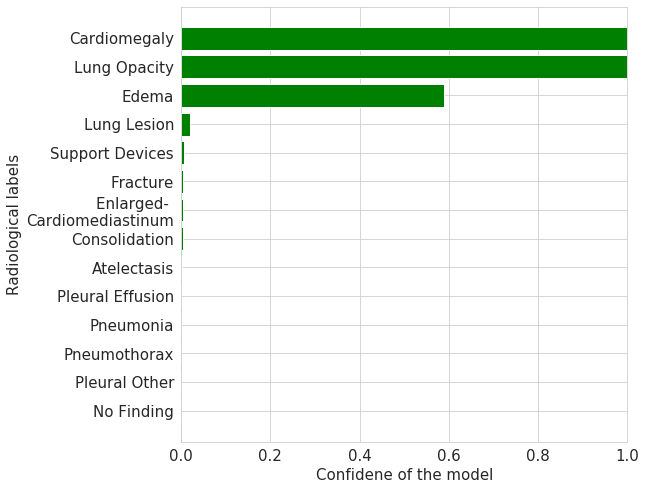

In [7]:
df = pd.DataFrame({'classes' : classes, 'predictions' : predictions[0]})
df = df.sort_values('predictions')

plt.figure(figsize=(8,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0, 1)
plt.barh(df['classes'], df['predictions'], color='green')
plt.xlabel('Confidene of the model', fontsize=15)
plt.ylabel('Radiological labels', fontsize=15)
plt.show()

In [8]:
import keras.backend as K
import tensorflow as tf

def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th': #keras.backend.image_data_format()
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)


def get_heatmap(gc):
    """Convert 2D heatmap to 3D for plotting"""
    # Get the color map
    cm = plt.get_cmap('jet')
    # Apply the colormap like a function to any array:
    gc3 = cm(gc)
    gc3 = gc3[:, :, :3].astype('float32') 
    return gc3

def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = np.array(Image.fromarray(cam).resize((image.shape[1], image.shape[2])))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam


def get_gradcam(uploaded_file, model, layer_name):
    # Load and process image
    image = preprocess_image(uploaded_file)
    # Add batch axis
    image = np.expand_dims(image, axis=0)
    # GradCAM
    gc = grad_cam(model, image, -1, layer_name)
    # Add channel axis
    gc = get_heatmap(gc)
    # Rescale
    heatmap_rs = np.uint8(255 * gc)
    return heatmap_rs

In [9]:
g_cam = get_gradcam(uploaded_file, model, 'conv5_block16_2_conv')
g_cam.shape

(224, 224, 3)

In [10]:
orig_image = np.array(Image.open(uploaded_file))
# Check that images are 2D arrays
if len(orig_image.shape) > 2:
    orig_image = orig_image[:, :, 0]
# Convert to 3-channel
orig_image = np.stack((orig_image, orig_image, orig_image), axis=-1)

In [11]:
orig_heatmap = cv2.resize(g_cam, (orig_image.shape[1], orig_image.shape[0]))
orig_heatmap.shape

(261, 300, 3)

In [12]:
orig_heatmap.shape

(261, 300, 3)

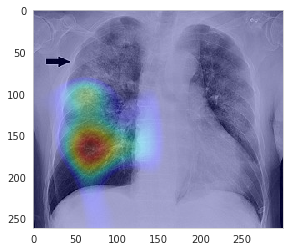

In [13]:
# Superimpose the heatmap on original image
superimposed_img = orig_heatmap * 0.5 + orig_image
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
plt.imshow(superimposed_img)
plt.grid(False)